## 玉山人工智慧公開挑戰賽2019夏季賽 - 台灣不動產AI神預測 

- House price: Predict sales prices
- 購買屬於自己的房子，是我們一生中的大事，評估房子的好壞，不僅要考慮房子的大小、屋齡，甚至連附近的生活機能和未來發展性都是一大考量因素。然而在眾多的考量中，什麼才是影響房價高低至關重要的因素呢？

In [276]:
import numpy as np
import pandas as pd
import re
from tqdm import tqdm

from scipy.special import boxcox1p
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score

from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
import lightgbm as lgb
import xgboost as xgb

import scipy.stats as stats
from scipy.stats import norm, skew
import math
import gc

import hyperopt
from hyperopt import hp
from hyperopt import tpe
from hyperopt import Trials
from hyperopt import fmin
import csv
from timeit import default_timer as timer
from hyperopt import STATUS_OK, hp, tpe, Trials, fmin
import ast
from numpy.random import RandomState



import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Load the data

In [175]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

print("Train ", train.shape[0], "sales, and ", train.shape[1], "features" )
print("Test ", test.shape[0], "sales, and ", test.shape[1], "features" )

Train  60000 sales, and  235 features
Test  10000 sales, and  234 features


### EDA

There are 60,000 instances of training data and 10000 of test data. Total number of attributes equals 235, of which 233 is quantitative, Id (qualitative) and SalePrice. -> all are quantitative except ID

- **Missing Value**: 4 features have missing value in both train and test data: 'village_income_median', 'txn_floor', 'parking_price', 'parking_area'

- **Normal Distributaion on total price**: total_price doesn't follow normal distribution, so before performing regression it has to be transformed -> use standardisation since log total price follow gaussian distribution

- Data is non-linear

In [176]:
train["total_price"].describe()

count    6.000000e+04
mean     1.293727e+07
std      5.522463e+07
min      2.261495e+05
25%      2.433114e+06
50%      5.240482e+06
75%      1.123932e+07
max      5.088279e+09
Name: total_price, dtype: float64

In [177]:
quantitative = [f for f in train.columns if train[f].dtypes != 'object']
#quantitative.remove('total_price')
qualitative = [f for f in train.columns if train[f].dtypes == 'object']
print("qualitative data:", qualitative)

qualitative data: ['building_id']


In [178]:
print("train data type: ", train.get_dtype_counts())
print("test data type: ", test.get_dtype_counts())

train data type:  float64     37
int64      197
object       1
dtype: int64
test data type:  float64     36
int64      197
object       1
dtype: int64


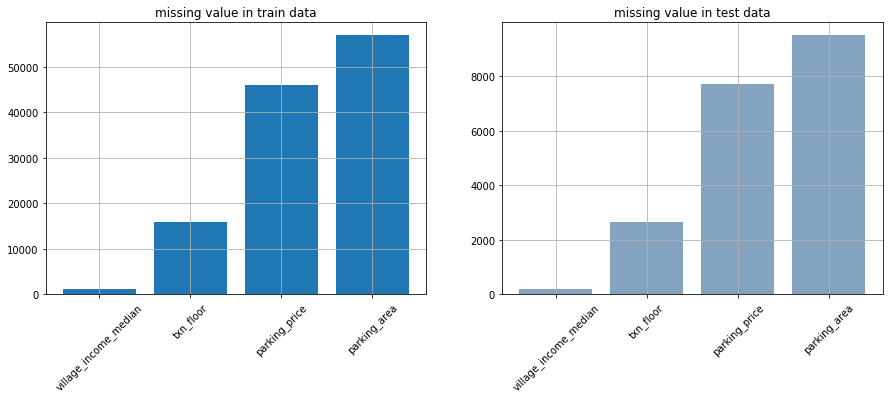

In [179]:
tr_missing = train.isnull().sum()
tr_missing = tr_missing[tr_missing > 0]
tr_missing.sort_values(inplace=True)
tr_missing = pd.DataFrame(tr_missing).reset_index()
tr_missing = tr_missing.rename(columns = {"index": "features", 0:"count"})

te_missing = test.isnull().sum()
te_missing = te_missing[te_missing > 0]
te_missing.sort_values(inplace=True)
te_missing = pd.DataFrame(te_missing).reset_index()
te_missing = te_missing.rename(columns = {"index": "features", 0:"count"})


def plot_missing(df_train, df_test):
    
    plt.figure(figsize=(15, 5)) 
    
    plt.subplot(1,2,1)
    plt.grid(b=None) # no grid line
    plt.bar(df_train["features"], df_train["count"])
    plt.title("missing value in train data", loc='center')
    plt.xticks(rotation=45)
    
    plt.subplot(1,2,2)
    plt.grid(b=None) # no grid line
    plt.bar(df_test["features"], df_test["count"], color=(0.2, 0.4, 0.6, 0.6))
    plt.title("missing value in test data", loc='center')
    plt.xticks(rotation=45)
    
    plt.show()
    
plot_missing(tr_missing, te_missing)

Text(0.5, 1.0, 'Normal Distribution with log transform for total price (train)')

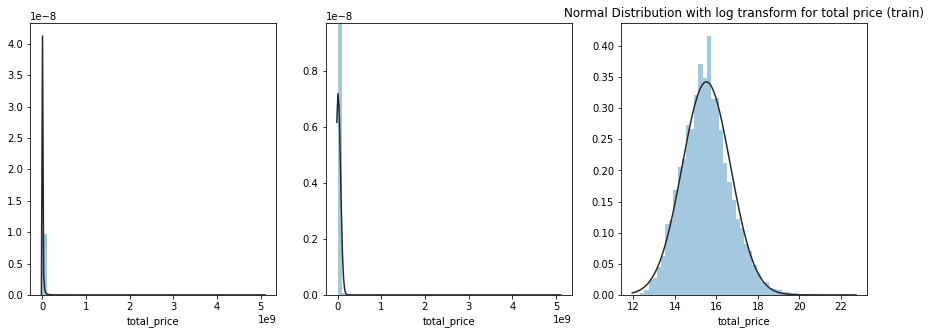

In [180]:
y = train['total_price']
log_price = train["total_price"].apply(lambda row: math.log(row))

f, axes = plt.subplots(1, 3, figsize=(15,5))

sns.distplot(y, kde=False, fit=stats.johnsonsu, ax = axes[0])
plt.title('Johnson SU')

sns.distplot(y, kde=False, fit=stats.norm, ax = axes[1])
plt.title('Normal Distribution')

sns.distplot(log_price, kde=False, fit=stats.norm, ax = axes[2])
plt.title('Normal Distribution with log transform for total price (train)')

In [181]:
# The Shapiro-Wilk test evaluates a data sample and quantifies how likely it is that the data was drawn from a Gaussian distribution
warnings.filterwarnings("ignore")

test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)

# not reject null hypothesis -> features with normal distribution
print("features with normal distribution: \n", list(pd.DataFrame(normal[normal==False]).reset_index()["index"])) 

features with normal distribution: 
 ['I_index_5000', 'I_index_10000', 'II_index_5000', 'II_index_10000', 'III_index_5000', 'III_index_10000', 'IV_index_10000', 'V_index_5000', 'V_index_10000', 'VI_index_5000', 'VI_index_10000', 'VII_index_5000', 'VII_index_10000', 'VIII_index_5000', 'VIII_index_10000', 'IX_index_10000', 'X_index_5000', 'X_index_10000', 'XII_index_5000', 'XII_index_10000', 'XIV_index_5000', 'XIV_index_10000']


In [ ]:
# check relationship with target

check0 = ['city', 'total_floor', 'building_type', 'building_use', 'building_complete_dt', 
        'parking_way','txn_floor','land_area', 'building_area', 'lat', 'lon']
check0.append("total_price")

sns.set()
sns.pairplot(train[check0], size = 2.5)
plt.show();

In [ ]:
check1 = ['doc_Rate','master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate',
         'junior_rate', 'elementary_rate', 'born_rate', 'death_date',
         'marriage_rate', 'divorce_rate']
check1.append("total_price")

sns.set()
sns.pairplot(train[check1], size = 2.5)
plt.show();

In [ ]:
check2 = [i for i in train.columns if re.search("^[A-Z]{1,5}[_]10$", i, re.IGNORECASE)!=None] 
check2.append("total_price")

sns.set()
sns.pairplot(train[check2], size = 2.5)
plt.show();

In [ ]:
check3 = [i for i in train.columns if re.search("^[A-Z]{1,5}[_]5000$", i, re.IGNORECASE)!=None] 
check3.append("total_price")

sns.set()
sns.pairplot(train[check3], size = 2.5)
plt.show();

In [ ]:
check4 = [col for col in train.columns if re.search("^[A-Z]{1,4}[_]index[_]50$", col, re.IGNORECASE)!=None]
check4.append("total_price")

sns.set()
sns.pairplot(train[check4], size = 2.5)
plt.show();

In [ ]:
check4 = [col for col in train.columns if re.search("^[A-Z]{1,4}[_]MIN$", col, re.IGNORECASE)!=None]
check4.append("total_price")

sns.set()
sns.pairplot(train[check4], size = 2.5)
plt.show();

In [ ]:
check5 = ["parking_area","parking_price"]
check5.append("total_price")

sns.set()
sns.pairplot(train[check5], size = 2.5)
plt.show();

In [ ]:
#total_price correlation matrix
k = 10 #number of variables for heatmap
corrmat = train.corr()
cols = corrmat.nlargest(k, 'total_price')['total_price'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
var = 'building_area'
data = pd.concat([np.log(train['total_price']), train[var]], axis=1)
data.plot.scatter(x=var, y='total_price', ylim=(10,25));

In [ ]:
var = 'land_area'
data = pd.concat([np.log(train['total_price']), train[var]], axis=1)
data.plot.scatter(x=var, y='total_price', ylim=(10,25));

In [ ]:
var = 'doc_Rate'
data = pd.concat([np.log(train['total_price']), train[var]], axis=1)
data.plot.scatter(x=var, y='total_price', ylim=(10,25));

In [ ]:
var = 'master_rate'
data = pd.concat([np.log(train['total_price']), train[var]], axis=1)
data.plot.scatter(x=var, y='total_price', ylim=(10,25));

In [ ]:
var = 'bachelor_rate'
data = pd.concat([np.log(train['total_price']), train[var]], axis=1)
data.plot.scatter(x=var, y='total_price', ylim=(10,25));

In [ ]:
# Data is non-linear (skip first -> take too long)

# features = [col for col in train.columns if col not in ["building_id", "total_price"]]
# model = TSNE(n_components=2, random_state=0, perplexity=50)

# X = train[features].fillna(0).values
# tsne = model.fit_transform(X)

# std = StandardScaler()
# s = std.fit_transform(X)

# pca = PCA(n_components=30)
# pca.fit(s)
# pc = pca.transform(s)
# kmeans = KMeans(n_clusters=5)
# kmeans.fit(pc)

# fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
# sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
# print(np.sum(pca.explained_variance_ratio_))

### Check outlier of total_price

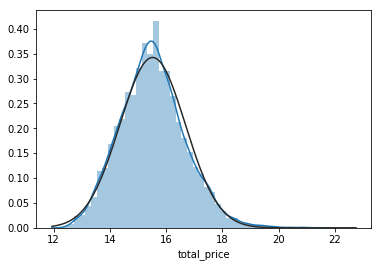

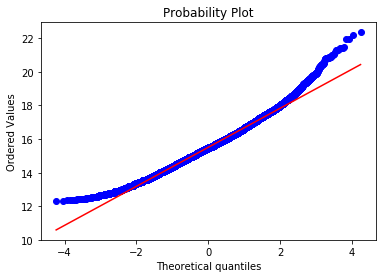

In [182]:
sns.distplot(np.log1p(train['total_price']), fit=norm);
fig = plt.figure()
res = stats.probplot(np.log(train['total_price']), plot=plt)

In [183]:
saleprice_scaled = StandardScaler().fit_transform(train['total_price'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-0.23017315]
 [-0.23010388]
 [-0.22998979]
 [-0.22996102]
 [-0.22996102]
 [-0.22995864]
 [-0.22995858]
 [-0.22979471]
 [-0.22979471]
 [-0.22979471]]

outer range (high) of the distribution:
[[32.06192385]
 [34.34089613]
 [35.49966166]
 [36.67109193]
 [36.67109193]
 [39.05140902]
 [60.93762758]
 [60.93762758]
 [78.66305757]
 [91.90435661]]


### Handle Missing Value
* village_income_median
    * fill in median value by village/town/city  
* txn_floor
    * fill na with None
* parking_price; parking_area
    * too many missing value -> drop
* if missing value > 15% then delete the variable directly


In [240]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
full = [train, test]

In [241]:
for df in full:
    print("original # of missing vluae:", df["village_income_median"].isnull().sum())
    df['village_income_median'] = df.groupby(by=["village"])['village_income_median'].transform(lambda x: x.fillna(x.median()))
    print("After # of missing vluae:", df["village_income_median"].isnull().sum())
    df['village_income_median'] = df.groupby(by=["town"])['village_income_median'].transform(lambda x: x.fillna(x.median()))
    print("After # of missing vluae:", df["village_income_median"].isnull().sum())
    df['village_income_median'] = df.groupby(by=["city"])['village_income_median'].transform(lambda x: x.fillna(x.median()))
    print("After # of missing vluae:", df["village_income_median"].isnull().sum())

original # of missing vluae: 1142
After # of missing vluae: 797
After # of missing vluae: 0
After # of missing vluae: 0
original # of missing vluae: 184
After # of missing vluae: 144
After # of missing vluae: 0
After # of missing vluae: 0


In [242]:
for df in full:
    #df["txn_floor"] = df["txn_floor"].fillna("None")
    df["txn_floor"] = df["txn_floor"].fillna(30.0)
    df.drop("parking_price", axis=1, inplace=True)
    df.drop("parking_area", axis=1, inplace=True)

In [243]:
# add square
t = [col for col in train.columns if re.search("^[A-Z]{1,5}[_]index[_]\d{1,5}$", col, re.IGNORECASE)==None]
t_r = [col for col in t if col not in ["building_id", "building_material", "city", "building_type",
                                      "building_use", "parking_way", "parking_area","parking_price",
                                      "town", "village","town_population", "town_area", "total_price"]]
for df in full:
    for col in t_r:
        df[col+"_s"] = df[col]**2

In [244]:
# add interaction term

original_num = train.shape[1]
main_col = ["city", "town", "village"]
interact_col = [col for col in train.columns if re.search("[a-zA-Z]_rate$", col, re.IGNORECASE)!=None]

for df in full:
    for m_col in main_col:
        for i_col in interact_col:
            df[m_col+i_col+"_IT"] = df[m_col]*df[i_col]  
            
print("# of columns added: ", train.shape[1]-original_num)

# of columns added:  30


### Feature Engineer

* delete variable with no variation
* add FREQUENCY ENCODE for all
* check which is categorical which one is continuous/categorical variable
* remove outlier of total_price
* Standardisation continuous data (note: I do it separate for train and test)

In [245]:
# exclude column with no variation
test["total_price"] = -1
all_df = pd.concat([train, test])
original_shape = all_df.shape[1]
all_df = all_df.loc[:,all_df.apply(pd.Series.nunique) != 1]
print("# columns with no variation: ", original_shape-all_df.shape[1])

# columns with no variation:  22


In [246]:
train = all_df[:len(train)]
test = all_df[len(train):]

In [247]:
def encode_FE(df,col,test):
    cv = df[col].value_counts()
    nm = col+'_FE'
    df[nm] = df[col].map(cv)
    test[nm] = test[col].map(cv)
    test[nm].fillna(0,inplace=True)
    if cv.max()<=255:
        df[nm] = df[nm].astype('uint8')
        test[nm] = test[nm].astype('uint8')
    else:
        df[nm] = df[nm].astype('uint16')
        test[nm] = test[nm].astype('uint16')        
    return


In [248]:
# check fake data in test
test1 = test.drop(['building_id'], axis=1)

unique_samples = []
unique_count = np.zeros_like(test1)

feature = [col for col in train.columns if col not in ["building_id", "total_price"]]

for i in range(len(feature)):
    _, index_, count_ = np.unique(test1.loc[:, feature[i]], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], i] += 1

# Samples which have unique values are real the others are fake
real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

print("# of real data: ", len(real_samples_indexes))
print("# of fake data: ", len(synthetic_samples_indexes))

# of real data:  8872
# of fake data:  1128


In [249]:
comb = pd.concat([train,test.loc[real_samples_indexes]])

encode_features = [col for col in train.columns if col not in ['building_id', 'total_price']]
index_features = [col for col in train.columns if re.search("^[A-Z]{1,5}[_]index[_]\d{1,5}$", col, re.IGNORECASE)!=None]
square_features = [col for col in train.columns if re.search("_s$", col, re.IGNORECASE)!=None]
encode_features = list(set(encode_features)-set(index_features))
encode_features = list(set(encode_features)-set(square_features))

for col in encode_features: 
    encode_FE(comb, col ,test)
train = comb[:len(train)]; del comb
print('Added', len(encode_features) ,'new magic features!')

Added 191 new magic features!


In [250]:
# check feature types
# get possiblely categorical variable (need to add txn_floor into it) [5/5]
categorical_var=[]
for col in train.columns:
    if len(train[col].unique())>1 and train[col].dtypes=="int64":
        categorical_var.append(col)

categorical_var.append("txn_floor")

In [251]:
# should remove certain from the categorical variable list
to_remove = [i for i in categorical_var if re.search("^[A-Z]{1,5}[_]\d{1,5}$", i, re.IGNORECASE)!=None] 
to_remove.append("total_floor")
to_remove.append("txn_dt")
to_remove.append("building_complete_dt")
categorical_var = list(set(categorical_var)-set(to_remove))
to_remove = [col for col in categorical_var if re.search("_s$", col, re.IGNORECASE)!=None]
categorical_var = list(set(categorical_var)-set(to_remove))

print(categorical_var)

continuous_var = set(train.columns)-set(categorical_var) # not categorical_var

['XII_index_1000', 'IX_index_50', 'XI_index_5000', 'IX_index_500', 'V_index_50', 'VI_index_1000', 'II_index_500', 'building_type', 'XII_index_50', 'VII_index_50', 'VI_index_500', 'XI_index_50', 'IV_index_1000', 'IV_index_5000', 'XIII_index_1000', 'I_index_1000', 'XI_index_500', 'III_index_500', 'XI_index_10000', 'XII_index_500', 'town', 'building_use', 'IV_index_50', 'VIII_index_500', 'XIII_index_500', 'VII_index_500', 'txn_floor', 'IX_index_1000', 'VIII_index_1000', 'building_material', 'XIV_index_50', 'IV_index_500', 'X_index_1000', 'II_index_50', 'village', 'XIII_index_5000', 'parking_way', 'VII_index_1000', 'VI_index_50', 'XIV_index_1000', 'VIII_index_50', 'II_index_1000', 'III_index_50', 'XIII_index_10000', 'III_index_1000', 'XI_index_1000', 'V_index_500', 'I_index_500', 'X_index_500', 'XIII_index_50', 'I_index_50', 'V_index_1000', 'X_index_50', 'city', 'XIV_index_500', 'IX_index_5000']


In [252]:
# modify skew features
continuous_var1 = [col for col in continuous_var if col not in ["building_id", "total_price"]]

skewed_feats = train[continuous_var1].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
print("# of skew continuous features: ", len(skewed_feats))

all_df2 = pd.concat([train, test])
lam = 0.15
for feat in skewed_feats:
    all_df2[feat] = boxcox1p(all_df2[feat], lam)

#all_df2[skewed_feats] = np.log1p(all_df2[skewed_feats])

# of skew continuous features:  341


# of outlier deleted in train (4, 584)


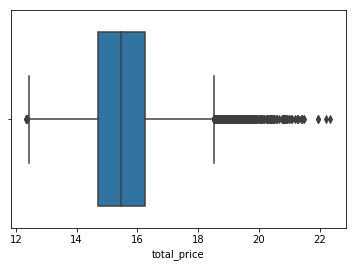

In [253]:
# exclude outlier 
sns.boxplot(x=np.log1p(train["total_price"]))
print("# of outlier deleted in train", train[np.log1p(train["total_price"])>21.5].shape)
train = train[np.log1p(train["total_price"])<=21.5]

In [254]:
# delete correlated features
del train["town_population"], train["town_area"] # collinearity with density
del test["town_population"], test["town_area"]

continuous_var.remove("town_population")
continuous_var.remove("town_area")

In [255]:
#----------------------------------------------
# Standardisation continuous data (note: should separate train and test?)
#----------------------------------------------

# exclude target variable
standardise_list = [col for col in continuous_var if col not in ["building_id", "total_price"]]
standarize = lambda x: (x-x.mean()) / x.std()

for col in standardise_list:
    train[col] = standarize(train[col])
    test[col] = standarize(test[col])

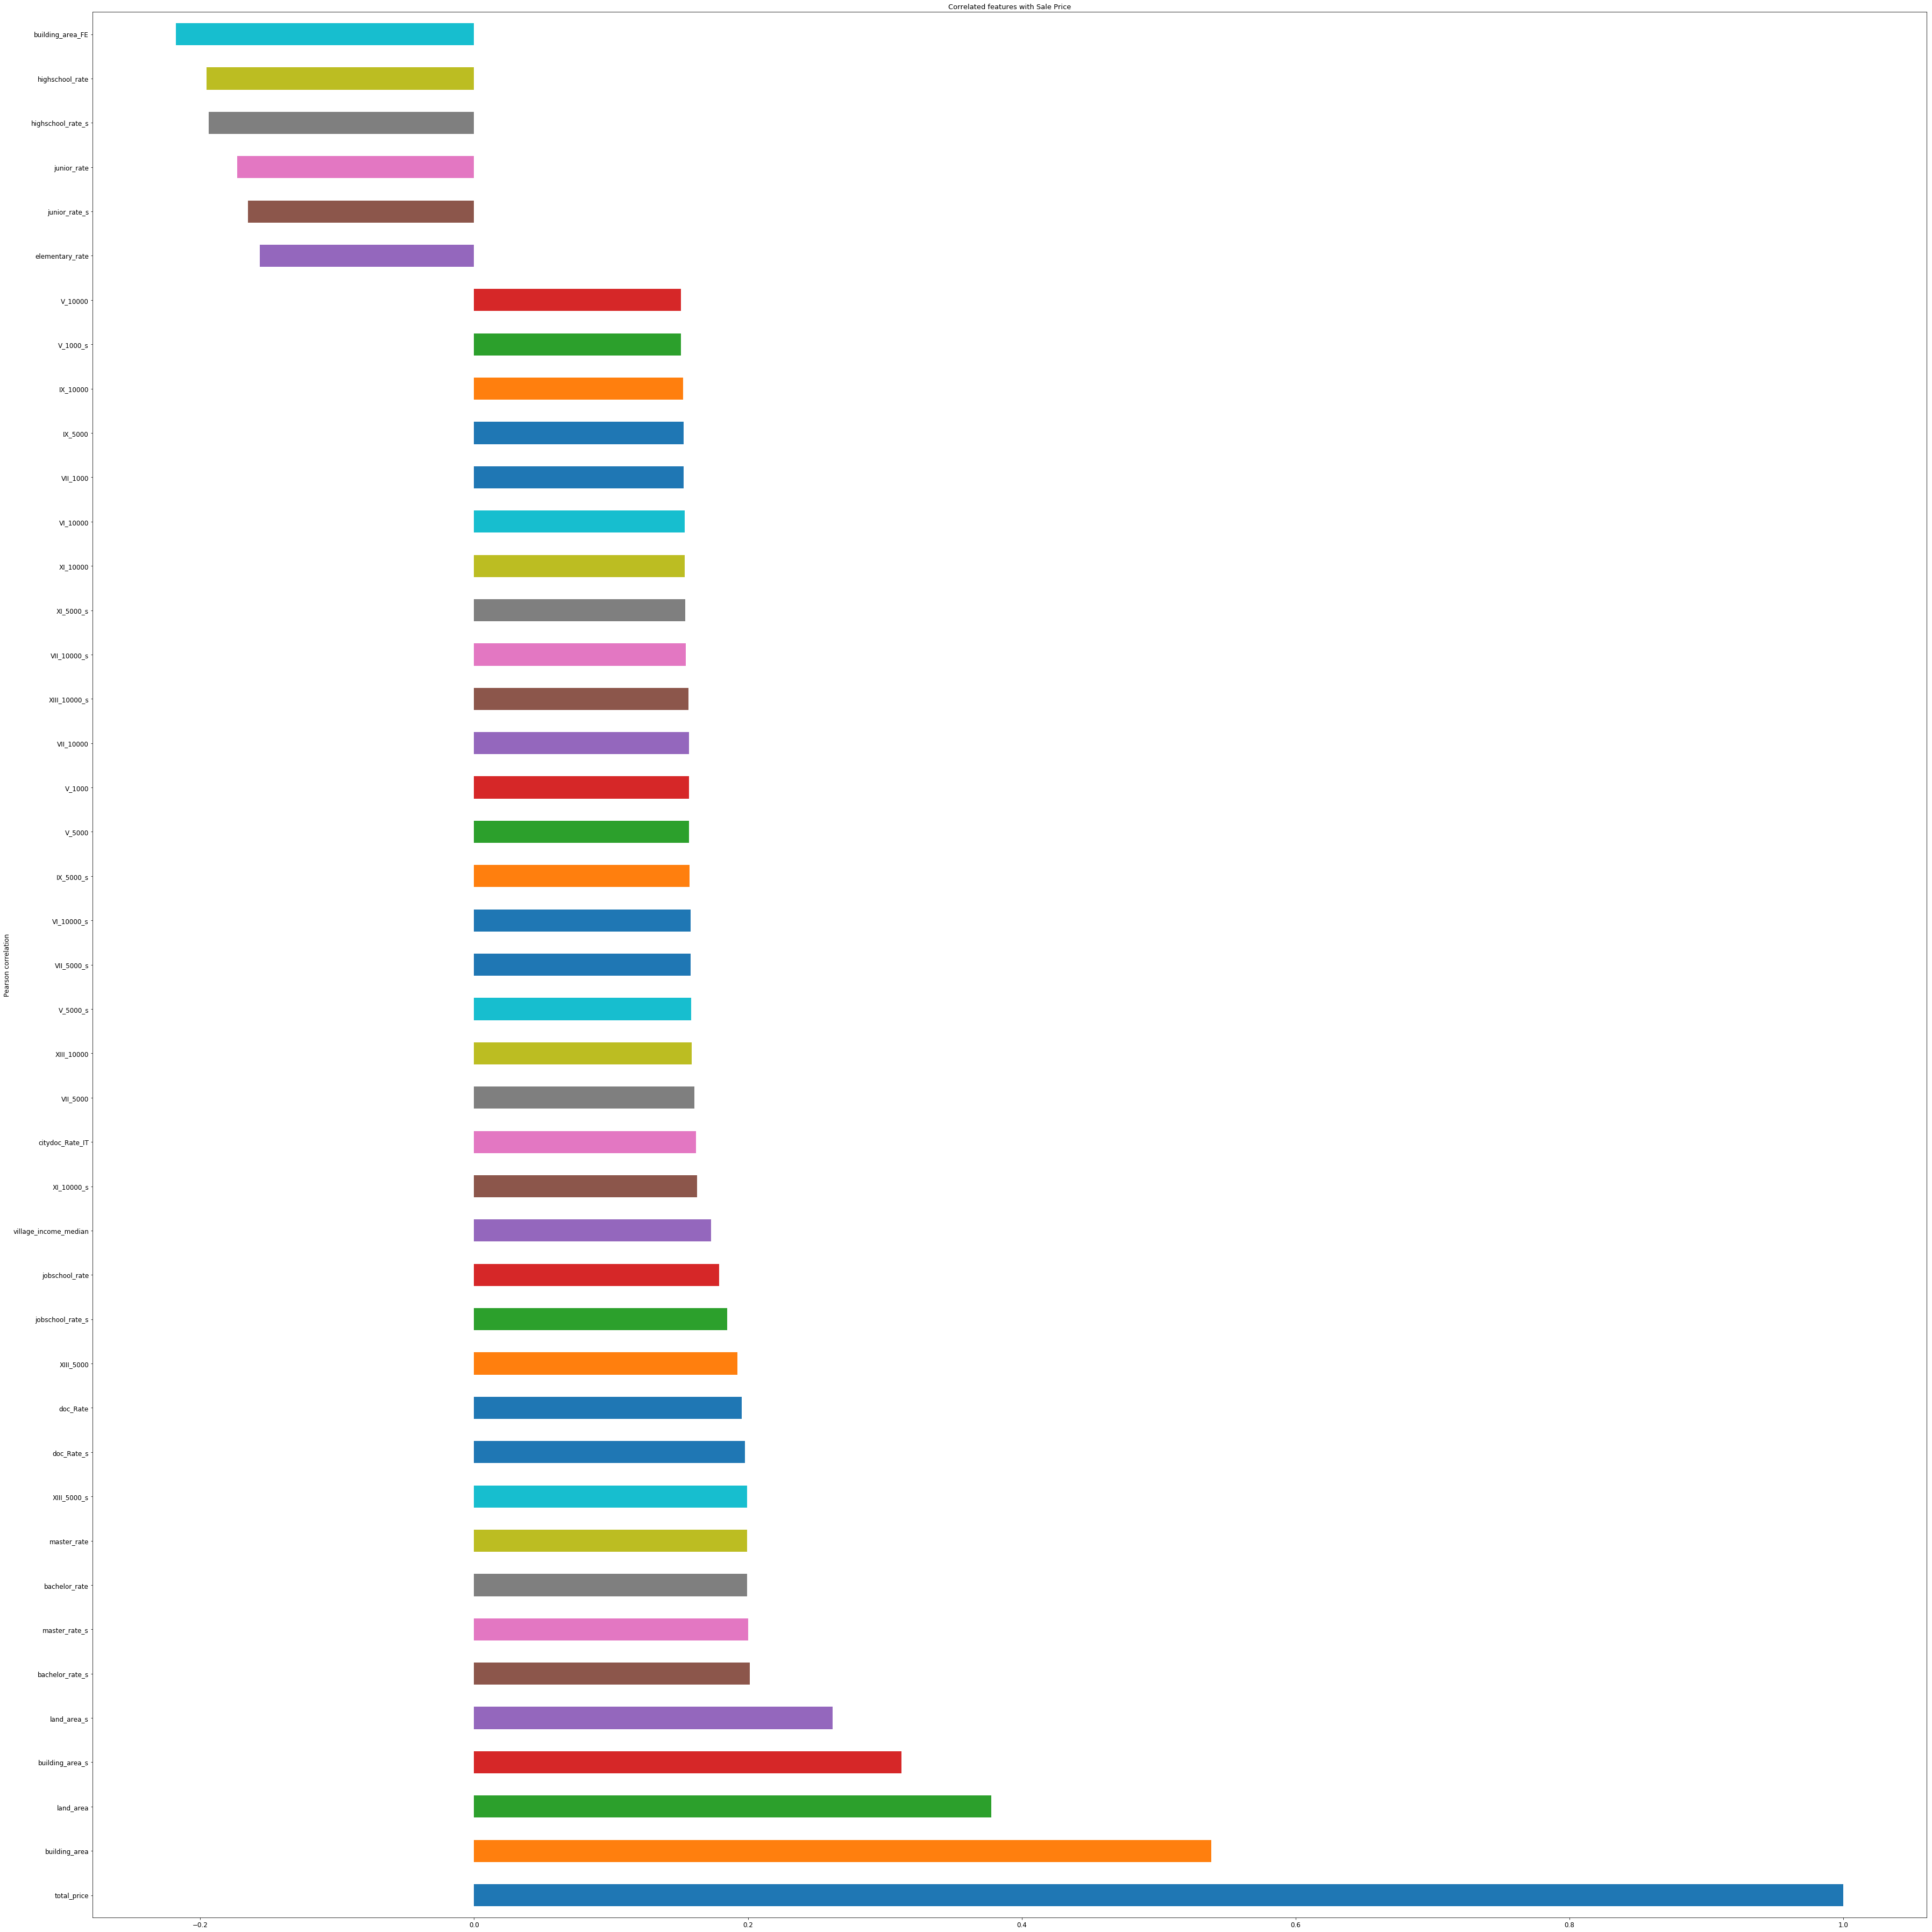

In [256]:
# check FE features
# col_check = [i for i in train.columns 
#              if re.search("\_FE$", i, re.IGNORECASE)!=None][:25]
# col_check.append("total_price")
# corr_sale=train[col_check].corr()["total_price"]

corr_sale=train[train.columns].corr()["total_price"]

fig, ax = plt.subplots(figsize = (50, 50))
#corr_sale[np.argsort(corr_sale, axis=0)[::-1]].plot(kind='barh')
corr_sale[(abs(corr_sale)>0.15)].sort_values(ascending= False).plot(kind='barh')
plt.tick_params(labelsize=12)
plt.ylabel("Pearson correlation",size=12)
plt.title('Correlated features with Sale Price', size=13)
plt.tight_layout()

In [257]:
# output csv file with FE
train.to_csv("train_FE_v2.csv", encoding = 'utf-8-sig', index=False)
test.to_csv("test_FE_v2.csv", encoding = 'utf-8-sig', index=False)

### Model

- lasso, gradientboost, lgbm
- Stacking: average those model
- Stacking: adding a Meta-model

In [258]:
for col in categorical_var:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

In [259]:
target = train["total_price"]
col_keep = [col for col in train.columns if col not in ["building_id", "total_price"]]
train2 = train[col_keep]
test2 = test[col_keep]

In [292]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train2, np.log1p(target), test_size=0.2, random_state=0)

In [293]:
#----------------------------------------------
# lgbm
#----------------------------------------------

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmsle',
    'num_leaves': 13,
    'max_depth': -1, 
    'learning_rate': 0.1,
    'verbose': 1}

num_round = 1000

n_iters = 5
predictions = np.zeros(len(test2))


for i in range(n_iters):   
       
    x_train, x_valid, y_train, y_valid = train_test_split(train2, np.log1p(target), 
                                                          test_size=0.2, random_state=i)
    
    trn_data = lgb.Dataset(x_train, label=y_train)
    val_data = lgb.Dataset(x_valid, label=y_valid)
    
    model = lgb.train(params, trn_data, num_round, 
                      valid_sets = [val_data], 
                      verbose_eval=1000)
    
    preidctions1 = model.predict(x_valid)
    
    print("--->", i , "<---")
    print('MAE:', metrics.mean_absolute_error(y_valid, preidctions1))
    print('MSE:', metrics.mean_squared_error(y_valid, preidctions1))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, preidctions1)))
    print("R square:", r2_score(y_valid, preidctions1))

    
    predictions += model.predict(test2, num_iteration = model.best_iteration) / n_iters
    

output_lgbm = test[["building_id"]]
output_lgbm["total_price"] = np.expm1(predictions)
output_lgbm.to_csv("submission_lgbm_FE.csv", index=False)    

---> 0 <---
MAE: 0.1534210478284025
MSE: 0.050697211508444376
RMSE: 0.22516041283592544
R square: 0.9624487630859657
---> 1 <---
MAE: 0.1509570736239387
MSE: 0.04757610482563755
RMSE: 0.21811947374234505
R square: 0.9647463256610798
---> 2 <---
MAE: 0.1498390737672327
MSE: 0.04658932995112949
RMSE: 0.21584561601091065
R square: 0.965697838331016
---> 3 <---
MAE: 0.15327660050799777
MSE: 0.04931188294858426
RMSE: 0.22206279055389774
R square: 0.9637267379659499
---> 4 <---
MAE: 0.15433859530587418
MSE: 0.04931663692957847
RMSE: 0.2220734944327631
R square: 0.9636306086280326


- get low score

In [270]:
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import RobustScaler
# from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor

# lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
# GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
#                                    max_depth=4, max_features='sqrt',
#                                    min_samples_leaf=15, min_samples_split=10, 
#                                    loss='huber', random_state =5)
# model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
#                               learning_rate=0.05, n_estimators=720,
#                               max_bin = 55, bagging_fraction = 0.8,
#                               bagging_freq = 5, feature_fraction = 0.2319,
#                               feature_fraction_seed=9, bagging_seed=9,
#                               min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
# model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
#                              learning_rate=0.05, max_depth=3, 
#                              min_child_weight=1.7817, n_estimators=2200,
#                              reg_alpha=0.4640, reg_lambda=0.8571,
#                              subsample=0.5213, silent=1,
#                              random_state =7, nthread = -1)

In [264]:
# n_folds = 5

# def rmsle_cv(model):
#     kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train2.values)
#     rmse= np.sqrt(-cross_val_score(model, train2, np.log1p(target), scoring="neg_mean_squared_error", cv = kf))
#     return(rmse)

In [265]:
# %%time
# score_lasso = rmsle_cv(lasso)
# print("\nLasso score: {:.4f} ({:.4f})\n".format(score_lasso.mean(), score_lasso.std()))


Lasso score: 0.4681 (0.0139)



In [272]:
# %%time
# score_gb = rmsle_cv(GBoost)
# print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score_gb.mean(), score_gb.std()))

In [266]:
# %%time
# score_lgb = rmsle_cv(model_lgb)
# print("LGBM score: {:.4f} ({:.4f})\n" .format(score_lgb.mean(), score_lgb.std()))

LGBM score: 0.2591 (0.0049)

CPU times: user 3min 38s, sys: 8.05 s, total: 3min 46s
Wall time: 1min 9s


In [277]:
# def rmsle(y, y_pred):
#     return np.sqrt(mean_squared_error(y, y_pred))

In [279]:
# model_lgb.fit(train2.values, np.log1p(target))
# lgb_train_pred = model_lgb.predict(train2.values)
# lgb_pred = np.expm1(model_lgb.predict(test2.values))
# print(rmsle(np.log1p(target), lgb_train_pred))

0.2608125786727965


In [ ]:
# output_lgbm = test[["building_id"]]
# output_lgbm["total_price"] = lgb_pred.reshape(-1,1)
# output_lgbm.to_csv("190512_submission_lgbm_FE.csv", index=False)

In [ ]:
# # simple stacking
# class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
#     def __init__(self, models):
#         self.models = models
        
#     # we define clones of the original models to fit the data in
#     def fit(self, X, y):
#         self.models_ = [clone(x) for x in self.models]
        
#         # Train cloned base models
#         for model in self.models_:
#             model.fit(X, y)

#         return self
    
#     #Now we do the predictions for cloned models and average them
#     def predict(self, X):
#         predictions = np.column_stack([
#             model.predict(X) for model in self.models_
#         ])
#         return np.mean(predictions, axis=1) 

In [ ]:
# %%time
# averaged_models = AveragingModels(models = (lasso, GBoost, model_lgb))

# score_avg = rmsle_cv(averaged_models)
# print("Averaged base models score: {:.4f} ({:.4f})\n".format(score_avg.mean(), score_avg.std()))

In [ ]:
# # advance stacking
# class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
#     def __init__(self, base_models, meta_model, n_folds=5):
#         self.base_models = base_models
#         self.meta_model = meta_model
#         self.n_folds = n_folds
   
#     # We again fit the data on clones of the original models
#     def fit(self, X, y):
#         self.base_models_ = [list() for x in self.base_models]
#         self.meta_model_ = clone(self.meta_model)
#         kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
#         # Train cloned base models then create out-of-fold predictions
#         # that are needed to train the cloned meta-model
#         out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
#         for i, model in enumerate(self.base_models):
#             for train_index, holdout_index in kfold.split(X, y):
#                 instance = clone(model)
#                 self.base_models_[i].append(instance)
#                 instance.fit(X[train_index], y[train_index])
#                 y_pred = instance.predict(X[holdout_index])
#                 out_of_fold_predictions[holdout_index, i] = y_pred
                
#         # Now train the cloned  meta-model using the out-of-fold predictions as new feature
#         self.meta_model_.fit(out_of_fold_predictions, y)
#         return self
   
#     #Do the predictions of all base models on the test data and use the averaged predictions as 
#     #meta-features for the final prediction which is done by the meta-model
#     def predict(self, X):
#         meta_features = np.column_stack([
#             np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
#             for base_models in self.base_models_ ])
#         return self.meta_model_.predict(meta_features)

In [ ]:
# %%time
# stacked_averaged_models = StackingAveragedModels(base_models = (model_lgb, GBoost),
#                                                  meta_model = lasso)

# score_stack = rmsle_cv(stacked_averaged_models)
# print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score_stack.mean(), score_stack.std()))

In [ ]:
# stacked_averaged_models.fit(train2.values, np.log1p(target))
# stacked_train_pred = stacked_averaged_models.predict(train2.values)
# stacked_pred = np.expm1(stacked_averaged_models.predict(test2.values))
# print(rmsle(np.log1p(target), stacked_train_pred))

In [ ]:
# output_stacking = test[["building_id"]]
# output_stacking["total_price"] = stacked_pred.reshape(-1,1)
# output_stacking.to_csv("submission_stacking_FE.csv", index=False)

### Archive

In [283]:
# # reverse some columns
# reverse_list = [col for col in train.columns if re.search("^[A-Z]{1,5}[_]\d{2,5}$|^[A-Z]{1,5}[_]MIN$", col, re.IGNORECASE)!=None]

# for df in full:
#     for col in reverse_list:
#         df[col] *= -1